[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/streaming-interruption.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239464-lesson-1-streaming)

# Streaming


## Streaming


In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

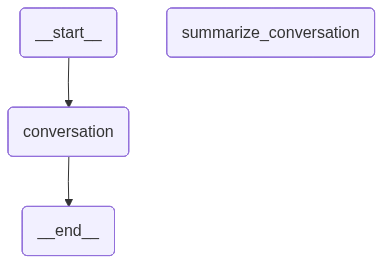

In [2]:
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0) 

# State 
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than eight messages, then we summarize the conversation
    if len(messages) > 8:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### Streaming full state

Now, let's talk about ways to [stream our graph state](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

`.stream` and `.astream` are sync and async methods for streaming back results. 
 
LangGraph supports a few [different streaming modes](https://langchain-ai.github.io/langgraph/how-tos/stream-values/) for [graph state](https://langchain-ai.github.io/langgraph/how-tos/stream-values/):
 
* `values`: This streams the full state of the graph after each node is called.
* `updates`: This streams updates to the state of the graph after each node is called.

![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

Let's look at `stream_mode="updates"`.

Because we stream with `updates`, we only see updates to the state after node in the graph is run.

Each `chunk` is a dict with `node_name` as the key and the updated state as the value.

In [6]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm akash")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content="Hello, Akash! How are you doing today? Is there anything specific you'd like to talk about or need help with?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 63, 'total_tokens': 88, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a788c5aef0', 'id': 'chatcmpl-CUzqBpimsrhLOgmMV6OeQMG8VnOAM', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--52eb0a99-5a7e-4ba4-adf1-0a9d9b259276-0', usage_metadata={'input_tokens': 63, 'output_tokens': 25, 'total_tokens': 88, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


Let's now just print the state update.

In [7]:
# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm akash")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Hi Akash! How can I assist you today?


Now, we can see `stream_mode="values"`.

This is the `full state` of the graph after the `conversation` node is called.

In [8]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm akash")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hello Lance! How can I assist you today?
================================ Human Message =================================

hi! I'm akash
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hello Lance! How can I assist you today?
================================ Human Message =================================

hi! I'm akash
================================== Ai Message ==================================

Hello Akash! How can I help you today?
---------------------------------------------------------------------------


### Streaming tokens

We often want to stream more than graph state.

In particular, with chat model calls it is common to stream the tokens as they are generated.

We can do this [using the `.astream_events` method](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node), which streams back events as they happen inside nodes!

Each event is a dict with a few keys:
 
* `event`: This is the type of event that is being emitted. 
* `name`: This is the name of event.
* `data`: This is the data associated with the event.
* `metadata`: Contains`langgraph_node`, the node emitting the event.

Let's have a look.

In [9]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="What's the meaning of life really?")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. N

The central point is that tokens from chat models within your graph have the `on_chat_model_stream` type.

We can use `event['metadata']['langgraph_node']` to select the node to stream from.

And we can use `event['data']` to get the actual data for each event, which in this case is an `AIMessageChunk`. 

In [10]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Whats the meaning of life really?")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--3f9c6379-c145-4407-a9f6-43241529156d')}
{'chunk': AIMessageChunk(content='The', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--3f9c6379-c145-4407-a9f6-43241529156d')}
{'chunk': AIMessageChunk(content=' meaning', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--3f9c6379-c145-4407-a9f6-43241529156d')}
{'chunk': AIMessageChunk(content=' of', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--3f9c6379-c145-4407-a9f6-43241529156d')}
{'chunk': AIMessageChunk(content=' life', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--3f9c6379-c145-4407-a9f6-43241529156d')}
{'chunk': AIMessageChunk(content=' is', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--3f9c6379-c145-4407-a9f6-43241529156d')}
{'chunk': AIMessageChunk

As you see above, just use the `chunk` key to get the `AIMessageChunk`.

In [11]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Whats the meaning of life really?")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

|The| meaning| of| life| is| a| question| that| has| been| ponder|ed| by| philosophers|,| theolog|ians|,| scientists|,| and| thinkers| for| centuries|,| and| it| often| depends| on| individual| beliefs|,| cultural| backgrounds|,| and| personal| experiences|.| Here| are| a| few| perspectives|:

|1|.| **|Ph|ilos|oph|ical| Perspective|**|:| Some| philosophical| views| suggest| that| life| has| no| inherent| meaning|,| and| it| is| up| to| each| individual| to| create| their| own| purpose|.| Exist|ential|ists|,| for| example|,| believe| that| meaning| is| not| given| to| us| but| is| something| we| must| construct| ourselves|.

|2|.| **|Rel|igious| Perspective|**|:| Many| religions| offer| their| own| interpretations| of| life's| meaning|.| For| example|,| in| Christianity|,| life| is| often| seen| as| a| journey| to| fulfill| God's| will| and| attain| eternal| life|.| In| Buddhism|,| the| purpose| is| to| attain| enlightenment| and| escape| the| cycle| of| suffering|.

|3|.| **|Scientific

### using summarize_conversation within astream_events

In [ ]:

config = {"configurable": {"thread_id": "6"}}

#summary only triggers after 8 messages
new_convo = [
    HumanMessage(content="hello, i'm akash."),
    HumanMessage(content="I am interested in movies."),
    HumanMessage(content="What are the best movies of all time?"),
    HumanMessage(content="I believe that Pulp Fiction is one of the best movies of all time."),
    HumanMessage(content="Followed closely by the Shawshank Redemption."),
    HumanMessage(content="And then Forrest Gump."),
    HumanMessage(content="I prefer movies to TV shows."),
    HumanMessage(content="What are some other cool movies to know about"),
    HumanMessage(content="Or TV shows for that matter"),
]

async for event in graph.astream_events({"messages": new_convo}, config, version="v2"):
    node = event['metadata'].get('langgraph_node', '')
    event_type = event['event']
    
    print(f"Node: '{node}' | Event: '{event_type}'")

    if node == 'conversation' and event_type == "on_chat_model_stream":
        chunk = event["data"]["chunk"].content
        if chunk:
            print(chunk, end="|", flush=True)

    if node == 'summarize_conversation' and event_type == 'on_chain_end':
        summary = event['data']['output'].get('summary')
        print("\n\n" + "="*40)
        print(f"Summary: {summary}")
        print("="*40)

Node: '' | Event: 'on_chain_start'
Node: 'conversation' | Event: 'on_chain_start'
Node: 'conversation' | Event: 'on_chat_model_start'
Node: 'conversation' | Event: 'on_chat_model_stream'
Node: 'conversation' | Event: 'on_chat_model_stream'
Great|Node: 'conversation' | Event: 'on_chat_model_stream'
 to|Node: 'conversation' | Event: 'on_chat_model_stream'
 hear|Node: 'conversation' | Event: 'on_chat_model_stream'
 you're|Node: 'conversation' | Event: 'on_chat_model_stream'
 interested|Node: 'conversation' | Event: 'on_chat_model_stream'
 in|Node: 'conversation' | Event: 'on_chat_model_stream'
 expanding|Node: 'conversation' | Event: 'on_chat_model_stream'
 your|Node: 'conversation' | Event: 'on_chat_model_stream'
 movie|Node: 'conversation' | Event: 'on_chat_model_stream'
 and|Node: 'conversation' | Event: 'on_chat_model_stream'
 TV|Node: 'conversation' | Event: 'on_chat_model_stream'
 show|Node: 'conversation' | Event: 'on_chat_model_stream'
 repertoire|Node: 'conversation' | Event: 'on

### Streaming with LangGraph API


In [18]:
from langgraph_sdk import get_client

# This is the URL of the local development server
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

Let's [stream `values`](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_values/), like before.

In [19]:
# Create a new thread
thread = await client.threads.create()
# Input message
input_message = HumanMessage(content="What is love?")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="values"):
    print(event)

StreamPart(event='metadata', data={'run_id': '019a21d3-6078-76c2-9f17-4029b919d33d', 'attempt': 1})
StreamPart(event='values', data={'messages': [{'content': 'What is love?', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'e1116a6a-3370-4d6c-bfa3-2733608f9496'}]})
StreamPart(event='values', data={'messages': [{'content': 'What is love?', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'e1116a6a-3370-4d6c-bfa3-2733608f9496'}, {'content': 'Love is a complex and multifaceted emotion that can be difficult to define. It often refers to a deep feeling of affection, care, warmth, and attachment toward someone or something. Love can manifest in various forms, such as romantic love, familial love, platonic love, and self-love. It involves a set of behaviors, emotions, and beliefs associated with strong feelings of warmth, protectiveness, and respect for others. Love is a central theme in human relationships and has b

The streamed objects have: 

* `event`: Type
* `data`: State

In [20]:
from langchain_core.messages import convert_to_messages
thread = await client.threads.create()
input_message = HumanMessage(content="What is love?")
async for event in client.runs.stream(thread["thread_id"], assistant_id="agent", input={"messages": [input_message]}, stream_mode="values"):
    messages = event.data.get('messages',None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print('='*25)

content='What is love?' additional_kwargs={} response_metadata={} id='ac163701-e558-4226-8411-e3ebcc795bcb'
content='Love is a complex set of emotions, feelings, and beliefs associated with strong affection, warmth, and respect for another person. It can refer to romantic love, the love between family members, platonic love, or even the love of non-human entities, such as a pet or a principle. Love is often seen as a key component of human relationships and can also be a profound theme in art, literature, and philosophy. It is characterized by a deep connection, care, and commitment, and it can be both a deeply personal experience and a universal concept understood across different cultures and societies.' additional_kwargs={'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 132, 'output_tokens': 119, 'total_tokens': 251, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}, 'refusal': None} response_metadata={'token_usag

There are some new streaming mode that are only supported via the API.

For example, we can [use `messages` mode](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_messages/) to better handle the above case!

This mode currently assumes that you have a `messages` key in your graph, which is a list of messages.

All events emitted using `messages` mode have two attributes:

* `event`: This is the name of the event
* `data`: This is data associated with the event

In [21]:
thread = await client.threads.create()
input_message = HumanMessage(content="What is love?")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="messages"):
    print(event.event)

metadata
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
mess

We can see a few events: 

* `metadata`: metadata about the run
* `messages/complete`: fully formed message 
* `messages/partial`: chat model tokens

You can dig further into the types [here](https://langchain-ai.github.io/langgraph/cloud/concepts/api/#modemessages).

Now, let's show how to stream these messages. 

We'll define a helper function for better formatting of the tool calls in messages.

In [22]:
thread = await client.threads.create()
input_message = HumanMessage(content="Whats the meaning of life?")

def format_tool_calls(tool_calls):
    """
    Format a list of tool calls into a readable string.

    Args:
        tool_calls (list): A list of dictionaries, each representing a tool call.
            Each dictionary should have 'id', 'name', and 'args' keys.

    Returns:
        str: A formatted string of tool calls, or "No tool calls" if the list is empty.

    """

    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages",):
    
    # Handle metadata events
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)
    
    # Handle partial message events
    elif event.event == "messages/partial":
        for data_item in event.data:
            # Process user messages
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                # Extract relevant data from the event
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"AI: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata:
                    finish_reason = response_metadata.get("finish_reason", "N/A")
                    print(f"Response Metadata: Finish Reason - {finish_reason}")
                    
        print("-" * 50)

Metadata: Run ID - 019a21d4-043e-7557-b0de-6ddb602b2fe1
--------------------------------------------------
Response Metadata: Finish Reason - N/A
--------------------------------------------------
AI: The
Response Metadata: Finish Reason - N/A
--------------------------------------------------
AI: The meaning
Response Metadata: Finish Reason - N/A
--------------------------------------------------
AI: The meaning of
Response Metadata: Finish Reason - N/A
--------------------------------------------------
AI: The meaning of life
Response Metadata: Finish Reason - N/A
--------------------------------------------------
AI: The meaning of life is
Response Metadata: Finish Reason - N/A
--------------------------------------------------
AI: The meaning of life is a
Response Metadata: Finish Reason - N/A
--------------------------------------------------
AI: The meaning of life is a philosophical
Response Metadata: Finish Reason - N/A
--------------------------------------------------
AI: The